In [1]:
import torch
from torch import nn
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append('../')
import model
from utils import compute_psnr,evaluate_psnr

Using CPU ❌ 😭


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Using GPU. ✅')
else:
  device = torch.device('cpu')
  print('Using CPU ❌ 😭')

Using CPU ❌ 😭


Make a folder to save figures in:

In [4]:
if not(os.path.exists('../figures')):
    os.mkdir('../figures')

# Load validation data

In [5]:
# Load validation data
VALIDATION_PATH = '../../miniproject_dataset/val_data.pkl'
validation_noisy_imgs, validation_clean_imgs = torch.load(VALIDATION_PATH, map_location=device)
print('Number of validation images: ', validation_clean_imgs.shape[0])

Number of validation images:  1000


# Quantify performance

In [6]:
def load_model(model_name, model_path):
    net = model.Model()
    checkpoint = torch.load(model_path, map_location=device)
    if (model_name=='UNet'):
        net.model = model.UNet()
    elif (model_name=='TNet' or model_name=='TNet_L1'):
        net.model = model.TNet()
    elif (model_name=='TNet_batchnorm'):
        net.model = model.TNet(batchnorm=True)
    elif (model_name=='BaseNet'):
        net.model = model.BaseNet()
    else:
        raise ValueError('Invalid model name!')
    net.model.load_state_dict(checkpoint['model'])
    net.batch_size = checkpoint['batch_size']
    net.losses = checkpoint['losses']
    return net

In [9]:
model_list = ['UNet','TNet','TNet_batchnorm','TNet_L1']
results = torch.zeros((len(model_list),5))
for m,model_name in enumerate(model_list):
    print('Predicting '+model_name+' ...')
    for i in range(5):
        model_path = '../models/'+model_name+'_'+str(i)+'.pth'
        net = load_model(model_name, model_path)
        results[m,i] = evaluate_psnr(net, validation_noisy_imgs, validation_clean_imgs)

Predicting UNet ...
Predicting TNet ...
Predicting TNet_batchnorm ...
Predicting TNet_L1 ...


In [10]:
results

tensor([[25.3728, 25.2629, 25.2270, 25.1802, 25.1763],
        [25.3148, 25.3294, 25.3191, 25.3214, 25.3162],
        [25.2981, 25.3107, 25.3052, 25.2921, 25.2879],
        [24.5235, 24.4746, 24.4154, 24.4192, 24.4266]], grad_fn=<CopySlices>)

# Make plots of example predictions

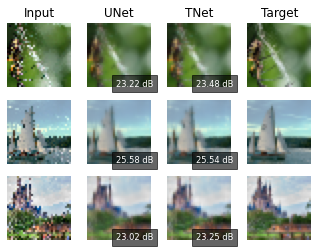

In [24]:
# Visualize predictions
example_image_nrs = [10,732,880] # These are three beautiful example images
nr_example_images = 3
model_list = ['UNet','TNet']
model_paths = ['../models/UNet_0.pth','../models/TNet_0.pth']

fig,ax = plt.subplots(nr_example_images,len(model_list)+2,figsize=(5.5,4))
random_nrs = torch.randint(validation_noisy_imgs.shape[0], size=(1,nr_example_images))

for m in range(len(model_list)):
  net = load_model(model_list[m], model_paths[m])
  for i in range(nr_example_images):

    nr = example_image_nrs[i]
    denoised = net.predict(validation_noisy_imgs[nr,:,:,:].unsqueeze(dim=0))
    dB = compute_psnr(denoised / 255, validation_clean_imgs[nr,:,:,:].unsqueeze(0) / 255)

    ax[i,m+1].imshow(denoised[0,:,:,:].permute(1,2,0).detach().cpu() / 255)
    (i==0) and ax[i,m+1].set_title(model_list[m])
    ax[i,m+1].axis('off')
    ax[i,m+1].text(23,30,f'%.2f dB'%(dB.item()), ha='center', va='center', 
                   color='w', backgroundcolor='k', fontsize='small',
                   bbox=dict(alpha=0.6, color='k'))

    if (m==0):
      ax[i,0].imshow(validation_noisy_imgs[nr,:,:,:].permute(1,2,0).cpu())
      (i==0) and ax[i,0].set_title('Input')
      ax[i,0].axis('off')

      ax[i,len(model_list)+1].imshow(validation_clean_imgs[nr,:,:,:].permute(1,2,0).cpu())
      (i==0) and ax[i,len(model_list)+1].set_title('Target')
      ax[i,len(model_list)+1].axis('off')

fig.savefig('../figures/example_outputs.pdf')